<a href="https://colab.research.google.com/github/larasauser/master/blob/main/imgprep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.3 MB/s eta 0:00:00


In [3]:
import os
import rasterio
import numpy as np

# Dossier contenant les images NDVI
folder_path = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10"

# Compteurs
images_with_anomalies = 0
total_images = 0

print("Vérification des valeurs NDVI hors plage [-1, 1] :\n")

# Parcours des fichiers
for fname in os.listdir(folder_path):
    if fname.endswith(".tif"):
        image_path = os.path.join(folder_path, fname)
        total_images += 1

        with rasterio.open(image_path) as src:
            ndvi = src.read(1).astype(np.float32)

        # Masquer les NaN pour éviter des faux positifs
        ndvi_no_nan = ndvi[~np.isnan(ndvi)]

        # Vérification hors plage
        has_anomalies = np.any((ndvi_no_nan < -1.0) | (ndvi_no_nan > 1.0))
        ndvi_min = np.min(ndvi_no_nan)
        ndvi_max = np.max(ndvi_no_nan)

        if has_anomalies:
            images_with_anomalies += 1
            print(f"❌ {fname} → NDVI hors plage : min={ndvi_min:.3f}, max={ndvi_max:.3f}")
        else:
            print(f"✅ {fname} → OK : min={ndvi_min:.3f}, max={ndvi_max:.3f}")

# Résumé
print("\nRésumé :")
print(f"Images avec valeurs NDVI hors [-1, 1] : {images_with_anomalies}/{total_images}")


Vérification des valeurs NDVI hors plage [-1, 1] :

✅ NDVI_2013-04-18.tif → OK : min=0.024, max=0.705
✅ NDVI_2013-06-05.tif → OK : min=0.014, max=0.583
✅ NDVI_2013-11-12.tif → OK : min=-0.043, max=0.599
✅ NDVI_2013-07-07.tif → OK : min=0.031, max=0.589
✅ NDVI_2013-11-28.tif → OK : min=-0.010, max=0.997
✅ NDVI_2013-09-25.tif → OK : min=0.015, max=0.900
✅ NDVI_2013-12-30.tif → OK : min=-0.010, max=1.000
✅ NDVI_2014-01-15.tif → OK : min=0.115, max=0.639
✅ NDVI_2014-03-20.tif → OK : min=-0.032, max=0.711
✅ NDVI_2014-05-23.tif → OK : min=0.011, max=0.711
✅ NDVI_2014-09-12.tif → OK : min=0.019, max=0.593
✅ NDVI_2014-06-08.tif → OK : min=0.052, max=0.571
✅ NDVI_2014-10-14.tif → OK : min=-0.015, max=0.994
✅ NDVI_2014-09-28.tif → OK : min=0.029, max=0.598
✅ NDVI_2015-01-02.tif → OK : min=-0.080, max=0.997
✅ NDVI_2015-01-18.tif → OK : min=0.026, max=0.909
✅ NDVI_2015-03-23.tif → OK : min=-0.007, max=0.529
✅ NDVI_2015-04-08.tif → OK : min=0.021, max=0.499
✅ NDVI_2014-10-30.tif → OK : min=0.004, m

In [4]:
import rasterio
import numpy as np

# Chemin vers ton image
image_path = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/NDVI_2013-10-18.tif'  # à adapter

with rasterio.open(image_path) as src:
    ndvi = src.read(1).astype(np.float32)

# 1. Min / Max brut
ndvi_min = np.nanmin(ndvi)
ndvi_max = np.nanmax(ndvi)

# 2. Anomalies hors NDVI
anomalies = (ndvi < -1.0) | (ndvi > 1.0)
num_anomalies = np.sum(anomalies)

# 3. Présence de NaN
num_nan = np.sum(np.isnan(ndvi))

# Résultats
print(f"Image analysée : {image_path}")
print(f"Valeur NDVI minimale (brute) : {ndvi_min}")
print(f"Valeur NDVI maximale (brute) : {ndvi_max}")
print(f"Nombre de pixels anormaux (hors [-1, 1]) : {num_anomalies}")
print(f"Nombre de pixels NaN : {num_nan}")


Image analysée : /content/drive/MyDrive/NDVI_grancy_Landsat8_10/NDVI_2013-10-18.tif
Valeur NDVI minimale (brute) : 0.017478791996836662
Valeur NDVI maximale (brute) : 0.5599645972251892
Nombre de pixels anormaux (hors [-1, 1]) : 0
Nombre de pixels NaN : 8787


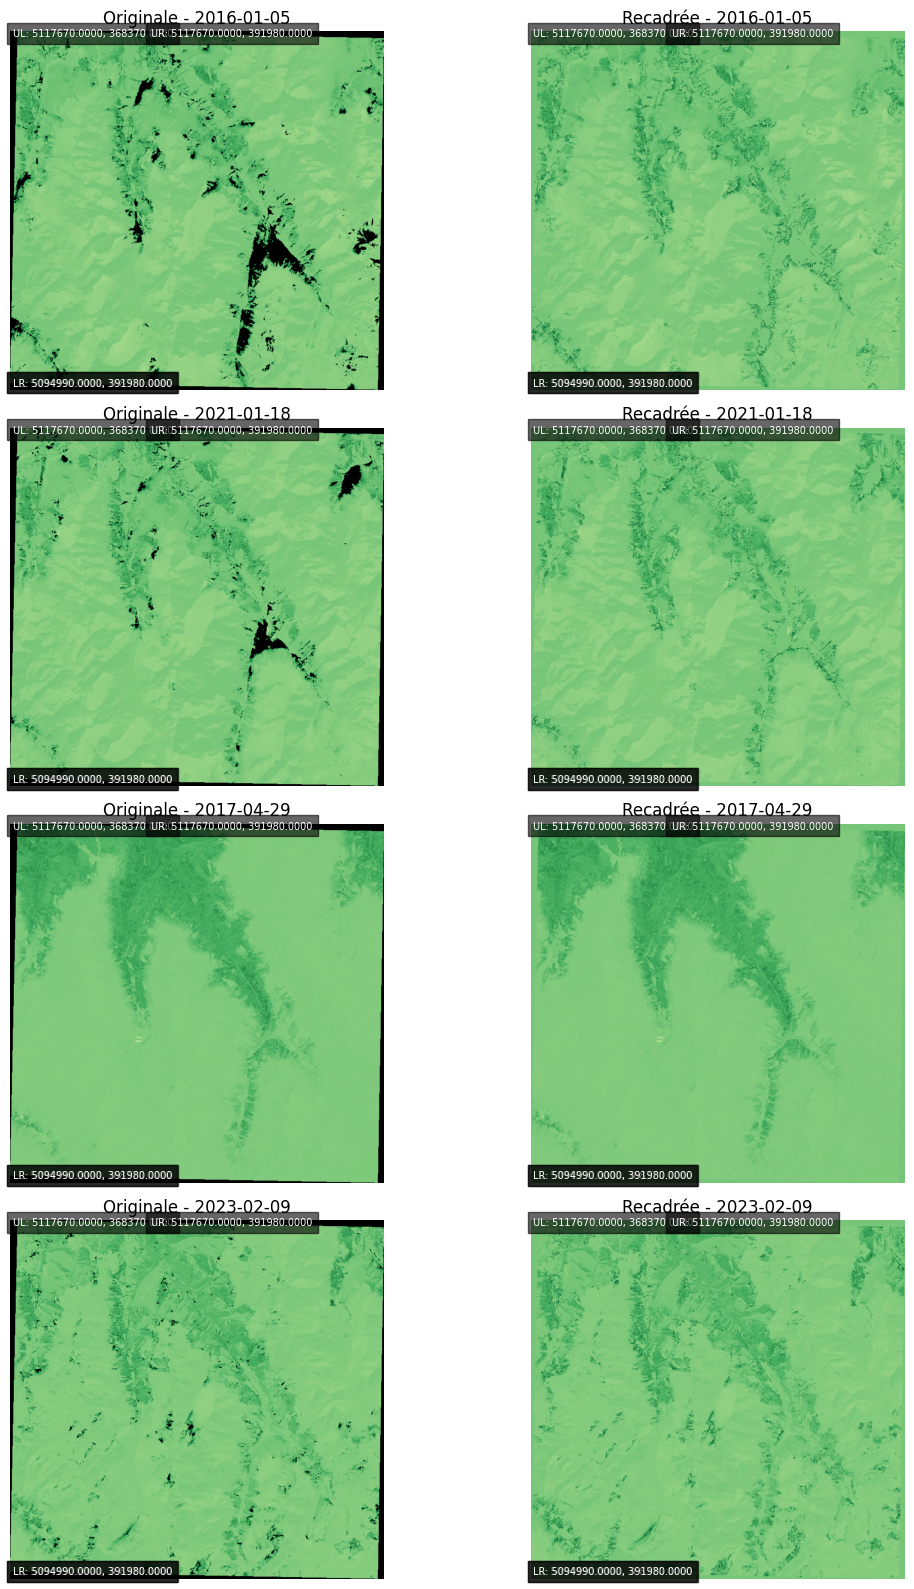

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
from shapely.geometry import shape, mapping
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import random
from scipy.ndimage import label

# --- Fonction de recadrage améliorée ---
def crop_using_mask_clean(image_path, output_path):
    with rasterio.open(image_path) as src:
        ndvi = src.read(1)
        mask_valid = ~np.isnan(ndvi)

        # Trouver la plus grande composante connexe (connected component)
        labeled_array, num_features = label(mask_valid)
        if num_features == 0:
            print(f"Aucun pixel valide dans {image_path}")
            return

        sizes = [(labeled_array == i).sum() for i in range(1, num_features+1)]
        largest_label = np.argmax(sizes) + 1
        mask_valid_clean = (labeled_array == largest_label)

        # Extraire polygones des pixels valides (largest connected component)
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(mask_valid_clean.astype(np.uint8), mask=mask_valid_clean, transform=src.transform))
        )
        valid_polygons = [shape(feat['geometry']) for feat in results if feat['properties']['raster_val'] == 1]

        if not valid_polygons:
            print(f"Aucun polygone valide trouvé dans {image_path}")
            return

        unified_poly = unary_union(valid_polygons)

        # Recadrage avec rasterio.mask
        out_image, out_transform = mask(src, [mapping(unified_poly)], crop=True)

        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

# --- Fonction pour charger image + coins ---
def load_image_and_metadata(path):
    with rasterio.open(path) as src:
        ndvi = src.read(1).astype(np.float32)
        transform = src.transform
        h, w = ndvi.shape
        corners = {
            'UL': rasterio.transform.xy(transform, 0, 0),
            'UR': rasterio.transform.xy(transform, 0, w - 1),
            'LL': rasterio.transform.xy(transform, h - 1, 0),
            'LR': rasterio.transform.xy(transform, h - 1, w - 1)
        }
    return ndvi, corners

# --- Paramètres dossiers ---
input_folder = "/content/drive/MyDrive/NDVI_herens_Landsat8_10"
output_folder = os.path.join(input_folder, "NDVI_herens_Landsat8_10_crop")
os.makedirs(output_folder, exist_ok=True)

# --- Recadrage de toutes les images ---
for fname in os.listdir(input_folder):
    if fname.endswith(".tif"):
        input_path = os.path.join(input_folder, fname)
        output_path = os.path.join(output_folder, fname)
        crop_using_mask_clean(input_path, output_path)

# --- Visualisation côte à côte de 4 images aléatoires ---
common_files = [
    f for f in os.listdir(output_folder)
    if f.endswith(".tif") and os.path.exists(os.path.join(input_folder, f))
]

sample_files = random.sample(common_files, 4)

fig, axs = plt.subplots(len(sample_files), 2, figsize=(12, 4 * len(sample_files)))

for i, fname in enumerate(sample_files):
    path_orig = os.path.join(input_folder, fname)
    path_crop = os.path.join(output_folder, fname)

    ndvi_orig, corners_orig = load_image_and_metadata(path_orig)
    ndvi_crop, corners_crop = load_image_and_metadata(path_crop)

    ndvi_orig_masked = np.ma.masked_invalid(ndvi_orig)
    ndvi_crop_masked = np.ma.masked_invalid(ndvi_crop)

    cmap = plt.cm.YlGn.copy()
    cmap.set_bad(color='black')

    date_str = fname.replace("NDVI_", "").replace(".tif", "")

    # Image originale
    ax1 = axs[i, 0]
    im1 = ax1.imshow(ndvi_orig_masked, cmap=cmap, vmin=-1, vmax=1)
    ax1.set_title(f"Originale - {date_str}")
    ax1.axis('off')
    h, w = ndvi_orig.shape
    for label, (lon, lat) in corners_orig.items():
        ax1.text(5 if 'L' in label else w - 150,
                 10 if 'U' in label else h - 10,
                 f"{label}: {lat:.4f}, {lon:.4f}",
                 fontsize=7, color='white',
                 bbox=dict(facecolor='black', alpha=0.6),
                 ha='left' if 'L' in label else 'right')

    # Image recadrée
    ax2 = axs[i, 1]
    im2 = ax2.imshow(ndvi_crop_masked, cmap=cmap, vmin=-1, vmax=1)
    ax2.set_title(f"Recadrée - {date_str}")
    ax2.axis('off')
    h, w = ndvi_crop.shape
    for label, (lon, lat) in corners_crop.items():
        ax2.text(5 if 'L' in label else w - 150,
                 10 if 'U' in label else h - 10,
                 f"{label}: {lat:.4f}, {lon:.4f}",
                 fontsize=7, color='white',
                 bbox=dict(facecolor='black', alpha=0.6),
                 ha='left' if 'L' in label else 'right')

plt.tight_layout()
plt.show()


Nombre d'images trouvées : 72
✅ Recadrage terminé pour toutes les images.


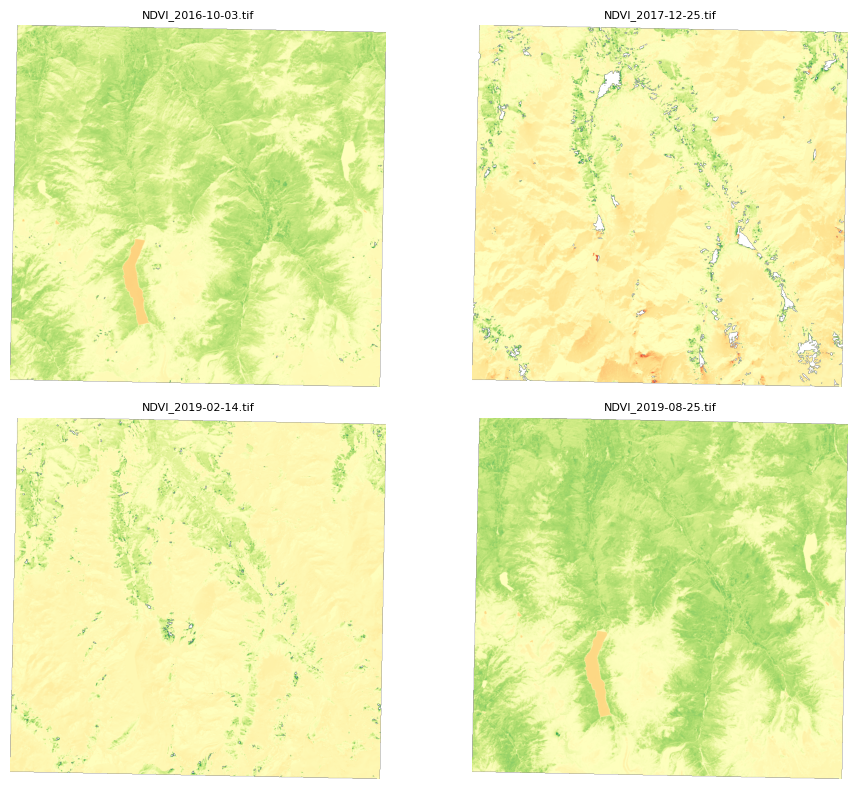

In [ ]:

#NONNONONNONON
import os
import glob
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# 1. Chemins
input_folder = "/content/drive/MyDrive/NDVI_herens_Landsat8_10"
output_folder = "/content/drive/MyDrive/NDVI_herens_Landsat8_10/NDVI_herens_Landsat8_10_crop"

# 2. Créer le dossier de sortie s’il n’existe pas
os.makedirs(output_folder, exist_ok=True)

# 3. Récupérer toutes les images .tif
tif_files = sorted(glob.glob(os.path.join(input_folder, "*.tif")))

print(f"Nombre d'images trouvées : {len(tif_files)}")

def crop_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        ndvi = src.read(1).astype(np.float32)
        profile = src.profile

    # Masque des pixels valides NDVI
    valid_mask = (~np.isnan(ndvi)) & (ndvi >= -1.0) & (ndvi <= 1.0)

    if not np.any(valid_mask):
        print(f"Aucun pixel NDVI valide dans : {image_path}")
        return

    # Trouver les lignes/colonnes utiles
    rows = np.any(valid_mask, axis=1)
    cols = np.any(valid_mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Recadrer l'image
    ndvi_cropped = ndvi[rmin:rmax+1, cmin:cmax+1]

    # Mettre à jour le profil (dimensions + fenêtre géo)
    transform = src.transform
    new_transform = rasterio.transform.from_origin(
        transform.c + cmin * transform.a,
        transform.f + rmin * transform.e,
        transform.a,
        transform.e
    )

    profile.update({
        'height': ndvi_cropped.shape[0],
        'width': ndvi_cropped.shape[1],
        'transform': new_transform
    })

    # Sauvegarder l'image recadrée
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(ndvi_cropped, 1)

# 4. Appliquer à toutes les images
for tif_file in tif_files:
    filename = os.path.basename(tif_file)
    output_path = os.path.join(output_folder, filename)
    crop_ndvi_image(tif_file, output_path)

print("✅ Recadrage terminé pour toutes les images.")

# 5. Afficher 4 images recadrées aléatoires
sample_files = random.sample(glob.glob(os.path.join(output_folder, "*.tif")), 4)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, img_path in zip(axes, sample_files):
    with rasterio.open(img_path) as src:
        ndvi = src.read(1)
    ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    ax.set_title(os.path.basename(img_path), fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.impute import SimpleImputer
# Create folder with imputed images
folder_path = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/'
output_folder = os.path.join(folder_path, "imputed")
os.makedirs(output_folder, exist_ok=True)

# Imputation function
def impute_ndvi_image(image_path, output_path):
    with rasterio.open(image_path) as src:
        image = src.read(1)
        meta = src.meta

    # Mask NaN
    nan_mask = np.isnan(image)

    # Imputation of NaN with median
    imputer = SimpleImputer(strategy='median')
    image_imputed = imputer.fit_transform(image)

    # Save the image
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(image_imputed, 1)

# Loop over every file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)
        impute_ndvi_image(input_path, output_path)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWar

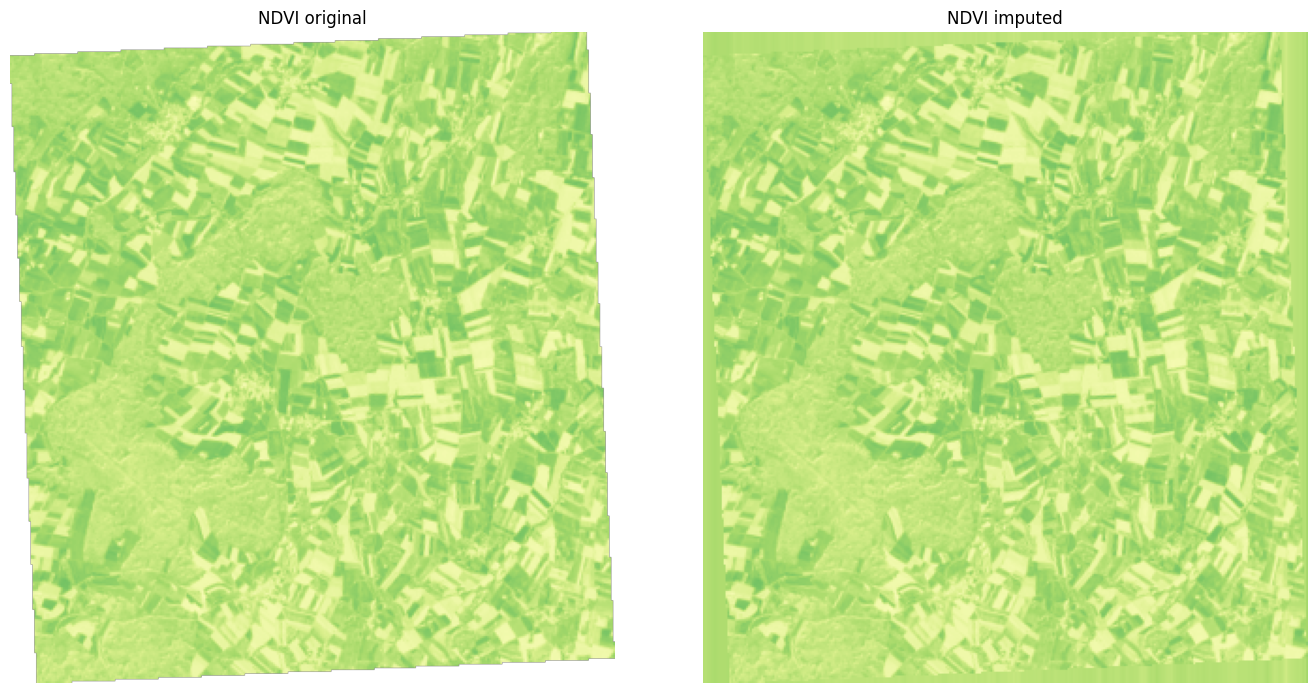

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def read_ndvi(path):
    with rasterio.open(path) as src:
        ndvi = src.read(1).astype(np.float32)
        nodata = src.nodata
        #if nodata is not None:
            #ndvi = np.where(ndvi == nodata, np.nan, ndvi)
    return ndvi

# Chemins des images à comparer
path_full = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/NDVI_2013-10-18.tif'
path_with_holes = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/NDVI_2013-10-18.tif'

# Lire les images
ndvi_full = read_ndvi(path_full)
ndvi_holes = read_ndvi(path_with_holes)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

vmin, vmax = -1, 1  # plage NDVI classique

axes[0].imshow(ndvi_full, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[0].set_title('NDVI original')
axes[0].axis('off')

axes[1].imshow(ndvi_holes, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[1].set_title('NDVI imputed')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [6]:
import os
import rasterio
import numpy as np
from glob import glob

def create_random_holes_nodata(img, min_size=25, max_size=75, max_holes=5, nodata_val=-9999):
    img_with_holes = img.copy()
    h, w = img.shape
    for _ in range(np.random.randint(1, max_holes + 1)):
        x = np.random.randint(0, w - max_size)
        y = np.random.randint(0, h - max_size)
        dx = np.random.randint(min_size, max_size + 1)
        dy = np.random.randint(min_size, max_size + 1)
        img_with_holes[y:y+dy, x:x+dx] = nodata_val
    return img_with_holes

input_dir = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed"
output_dir = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes'
os.makedirs(output_dir, exist_ok=True)

image_paths = glob(os.path.join(input_dir, '*.tif'))
print(f"Nombre d'images à traiter : {len(image_paths)}")

success_count = 0
fail_count = 0

for path in image_paths:
    try:
        with rasterio.open(path) as src:
            img = src.read(1).astype(np.float32)
            profile = src.profile

        # Ajouter trous avec min_size et max_size
        img_with_holes = create_random_holes_nodata(img)

        # Mise à jour profil
        profile.update(
            dtype=rasterio.float32,
            nodata=profile.get('nodata', -9999),
            compress='lzw'
        )

        out_path = os.path.join(output_dir, os.path.basename(path))
        with rasterio.open(out_path, 'w', **profile) as dst:
            dst.write(img_with_holes, 1)

        print(f"✔ Image traitée et sauvegardée : {os.path.basename(path)}")
        success_count += 1

    except Exception as e:
        print(f"❌ Erreur sur {os.path.basename(path)} : {e}")
        fail_count += 1

print(f"\nTraitement terminé. {success_count} images traitées avec succès, {fail_count} erreurs.")


Nombre d'images à traiter : 249
✔ Image traitée et sauvegardée : NDVI_2021-10-24(1).tif
✔ Image traitée et sauvegardée : NDVI_2018-11-01.tif
✔ Image traitée et sauvegardée : NDVI_2020-01-07.tif
✔ Image traitée et sauvegardée : NDVI_2020-06-24.tif
✔ Image traitée et sauvegardée : NDVI_2023-01-31.tif
✔ Image traitée et sauvegardée : NDVI_2023-11-08.tif
✔ Image traitée et sauvegardée : NDVI_2021-02-26(1).tif
✔ Image traitée et sauvegardée : NDVI_2013-11-12.tif
✔ Image traitée et sauvegardée : NDVI_2015-04-08.tif
✔ Image traitée et sauvegardée : NDVI_2019-02-21.tif
✔ Image traitée et sauvegardée : NDVI_2020-02-24(1).tif
✔ Image traitée et sauvegardée : NDVI_2016-03-09.tif
✔ Image traitée et sauvegardée : NDVI_2013-08-31.tif
✔ Image traitée et sauvegardée : NDVI_2017-05-22.tif
✔ Image traitée et sauvegardée : NDVI_2023-01-24.tif
✔ Image traitée et sauvegardée : NDVI_2023-04-14.tif
✔ Image traitée et sauvegardée : NDVI_2023-04-05(1).tif
✔ Image traitée et sauvegardée : NDVI_2023-08-11(1).tif

In [7]:
import rasterio

with rasterio.open('/content/drive/MyDrive/NDVI_grancy_Landsat8_10/NDVI_2013-10-18.tif') as src:
    width = src.width      # nombre de colonnes (pixels en X)
    height = src.height    # nombre de lignes (pixels en Y)
    print(f"Taille de l'image : {width} x {height} pixels")


Taille de l'image : 322 x 347 pixels


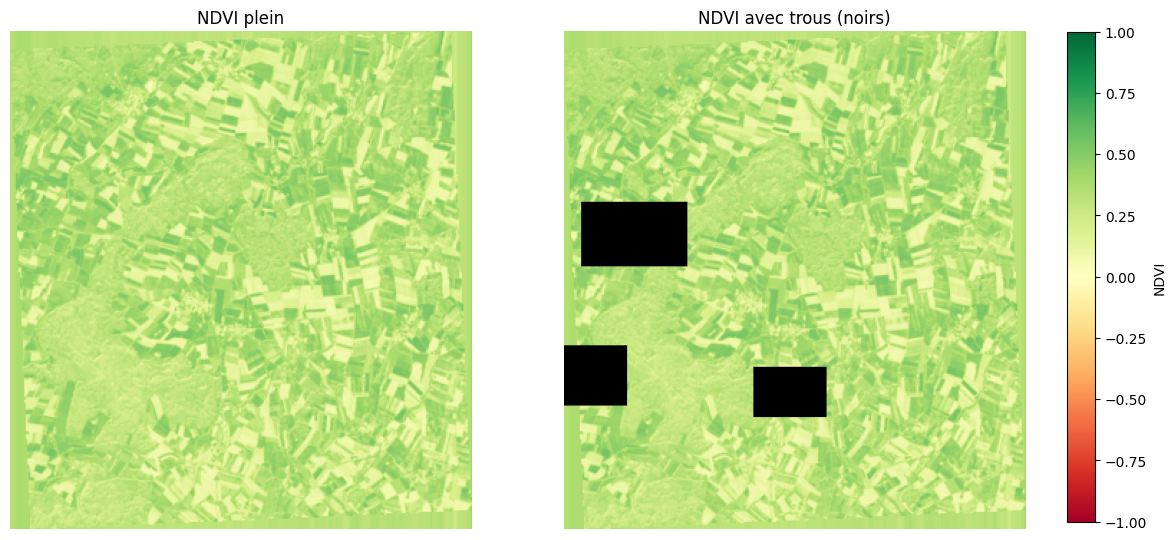

In [8]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def read_ndvi(path):
    with rasterio.open(path) as src:
        ndvi = src.read(1).astype(np.float32)
        nodata = src.nodata
        if nodata is not None:
            ndvi = np.where(ndvi == nodata, np.nan, ndvi)
    return ndvi

# Chemins des images à comparer
path_full = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/NDVI_2013-10-18.tif'
path_with_holes = '/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes/NDVI_2013-10-18.tif'

# Lire les images
ndvi_full = read_ndvi(path_full)
ndvi_holes = read_ndvi(path_with_holes)

# Supposons que ndvi_holes contient des NaN ou -99999
# On les masque pour les afficher en noir
masked_ndvi = np.ma.masked_where(np.isnan(ndvi_holes) | (ndvi_holes == -9999), ndvi_holes)

# Créer une copie de la colormap et définir les valeurs masquées en noir
cmap = plt.cm.RdYlGn.copy()
cmap.set_bad(color='black')  # couleur pour NaN ou valeurs masquées

vmin, vmax = -1, 1

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Image NDVI plein
axes[0].imshow(ndvi_full, cmap='RdYlGn', vmin=vmin, vmax=vmax)
axes[0].set_title('NDVI plein')
axes[0].axis('off')

# Image NDVI avec trous (affichés en noir)
im1 = axes[1].imshow(masked_ndvi, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1].set_title('NDVI avec trous (noirs)')
axes[1].axis('off')

# Colorbar à droite
plt.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax, label="NDVI")

plt.show()

